# Описание проекта: телекоммуникации

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг
Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных
Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['xtick.major.size'] = 10
mlp.rcParams['xtick.major.width'] = 3
mlp.rcParams['xtick.labelsize'] = 10
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 10
mlp.rcParams['ytick.major.width'] = 3
mlp.rcParams['ytick.labelsize'] = 10
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 15
mlp.rcParams['axes.titlesize'] = 15
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
PERIOD = pd.to_datetime('2020-02-01')

# Предобработка данных

In [2]:
df_contract = pd.read_csv('contract_new.csv')
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8


In [3]:
df_internet = pd.read_csv('internet_new.csv')
df_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [4]:
df_personal = pd.read_csv('personal_new.csv')
df_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [5]:
df_phone = pd.read_csv('phone_new.csv')
df_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [6]:
df = df_contract.merge(df_internet, how='left', on='customerID')
df = df.merge(df_personal, how='left', on='customerID')
df = df.merge(df_phone, how='left', on='customerID')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [7]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Не по всем клиентам есть информация по пользованию интернет-услагами или услугами телефонии. Заполним пропуски `unknow`

In [8]:
df = df.fillna('unknow')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [10]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

In [11]:
df[df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,unknow
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,unknow,unknow,unknow,unknow,unknow,unknow,unknow,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,unknow,unknow,unknow,unknow,unknow,unknow,unknow,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,unknow
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,unknow,unknow,unknow,unknow,unknow,unknow,unknow,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,unknow,unknow,unknow,unknow,unknow,unknow,unknow,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,unknow,unknow,unknow,unknow,unknow,unknow,unknow,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,unknow,unknow,unknow,unknow,unknow,unknow,unknow,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Несколько пользователей заключили договор только в этом месяце, пропуски в `TotalCharges` заменим на `MonthlyCharges`, т.к. они успели заплатить только за 1 месяц

In [12]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = df['MonthlyCharges']
df['TotalCharges'] = df['TotalCharges'].astype('float64')

In [13]:
df = df.set_index('customerID')
df['Churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
df['Churn'].value_counts()

0    5942
1    1101
Name: Churn, dtype: int64

# EDA

In [14]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,unknow,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,unknow,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,0


**BeginDate, EndDate**

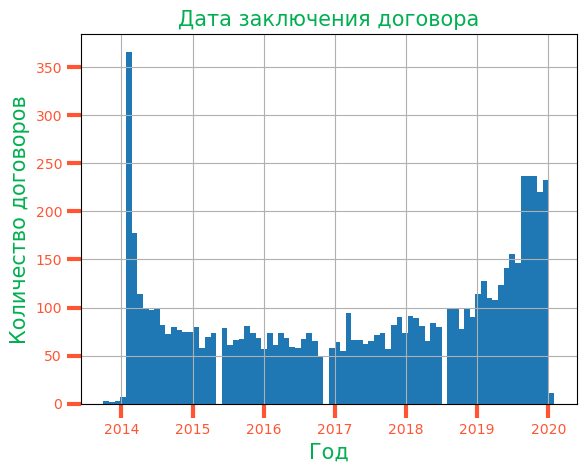

In [15]:
df['BeginDate'].hist(bins=80)
plt.title('Дата заключения договора')
plt.xlabel('Год')
plt.ylabel('Количество договоров')
plt.show()

Наблюдается пик в начале 2014 года, возможно в это время была образована компания и начала заключать договора с клиентами. Так же стоит отметить положительную динамику в последние 2 года

In [16]:
df_churn = df.loc[df['Churn'] == 1].copy()
df_churn['EndDate'] = pd.to_datetime(df_churn['EndDate'])
df_churn['period'] = (df_churn['EndDate'] - df_churn['BeginDate']).dt.days

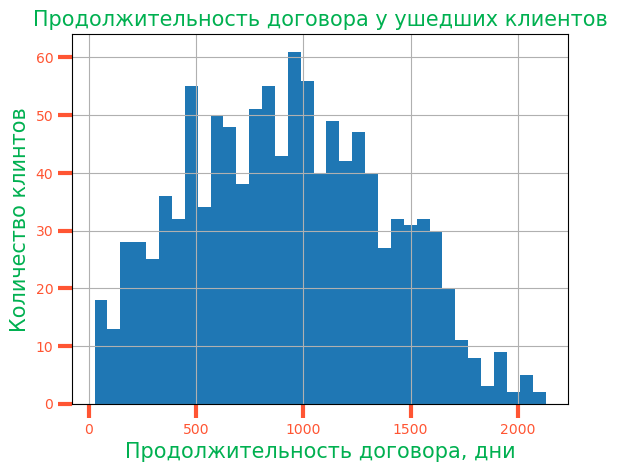

In [17]:
df_churn['period'].hist(bins=35)
plt.title('Продолжительность договора у ушедших клиентов')
plt.xlabel('Продолжительность договора, дни')
plt.ylabel('Количество клинтов')
plt.show()

Чаще всего люди расторгают договор в интервале 2-3 лет. С другой стороны клинтов со сроком договора >5 лет немного, то есть это только те, кто заключил договор в 2014-2015 году.

Анализ проводится на 2020-02-01, поэтому для клиентов с действующим договором, пропуски в столбце `EndDate` заменим этой датой и посчитаем продолжительность договоров `period_days` для всех клиентов. Удалим столбцы `BeginDate` и `EndDate`

In [18]:
df['EndDate'] = pd.to_datetime(df['EndDate'].replace('No', PERIOD))
df['period_days'] = (df['EndDate'] - df['BeginDate']).dt.days
df = df.drop(['BeginDate', 'EndDate'], axis=1)
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churn,period_days
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,unknow,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,unknow,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,0,153


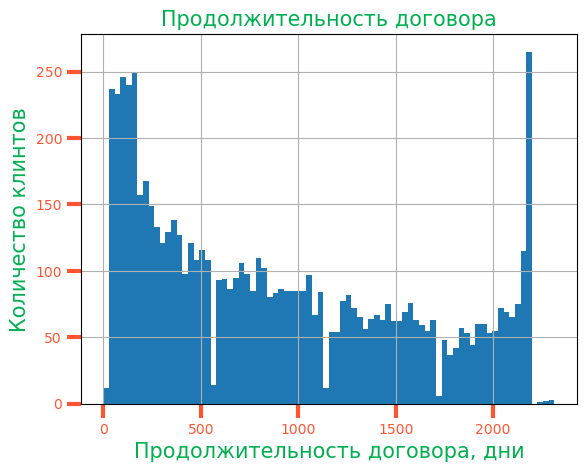

In [19]:
df['period_days'].hist(bins=80)
plt.title('Продолжительность договора')
plt.xlabel('Продолжительность договора, дни')
plt.ylabel('Количество клинтов')
plt.show()

**MonthlyCharges, TotalCharges, period_days**

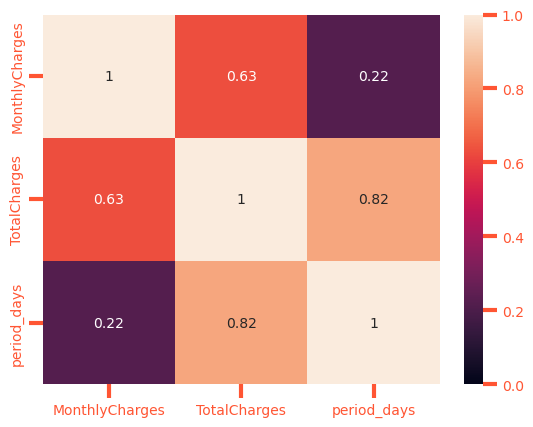

In [20]:
numeric_col = ['MonthlyCharges', 'TotalCharges', 'period_days']

sns.heatmap(df[numeric_col].corr(),
            xticklabels=numeric_col,
            yticklabels=numeric_col,
            vmin=0,
            vmax=1,
            annot=True)

plt.show()

У `TotalCharges` высокая корреляция с ежемесечным платежом и периодом договора. Удалим этот признак, чтобы избежать мультиколлинеарности.

In [21]:
df = df.drop('TotalCharges', axis=1)

**Cat_features**

In [22]:
df.dtypes

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
MultipleLines        object
Churn                 int64
period_days           int64
dtype: object

In [23]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

cat_features = df.select_dtypes(include='object').columns
cat_features

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines'],
      dtype='object')

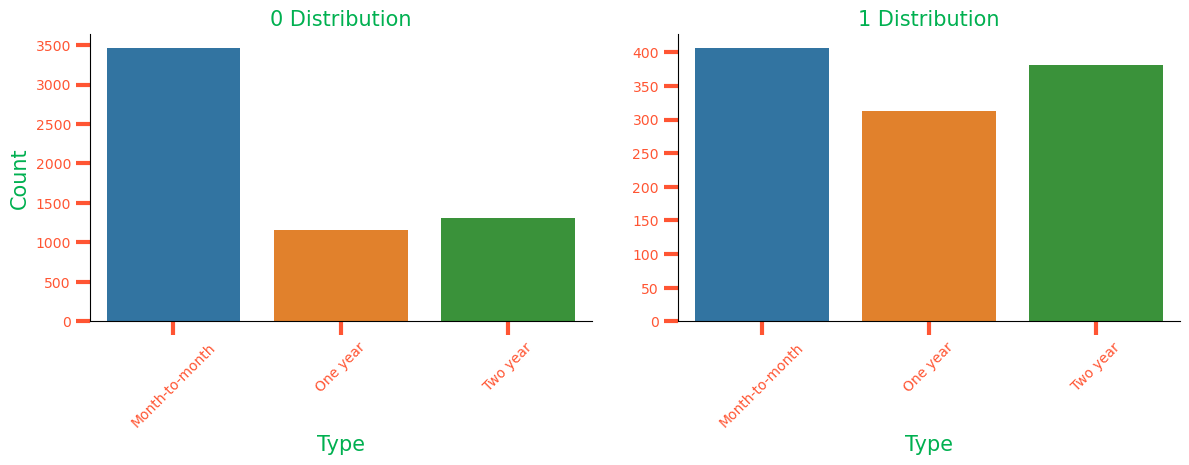

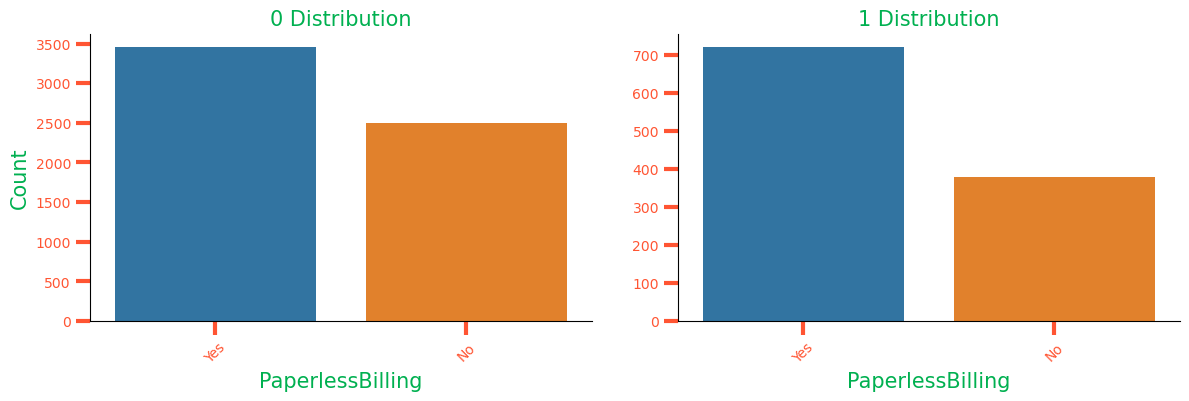

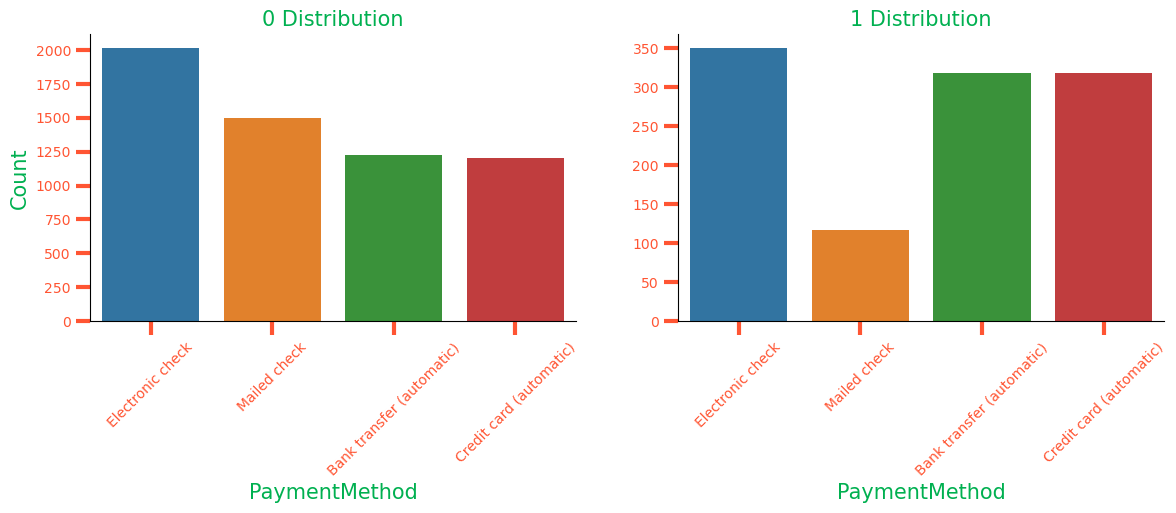

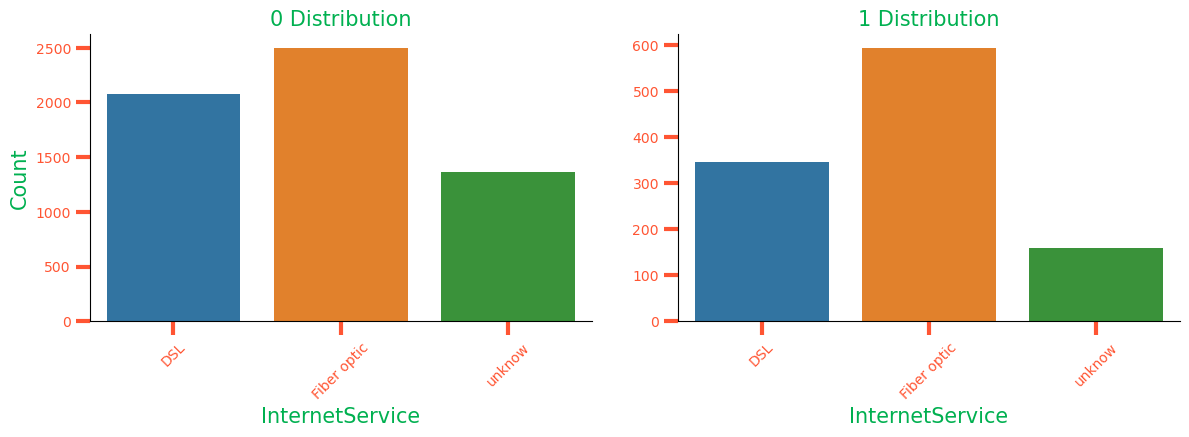

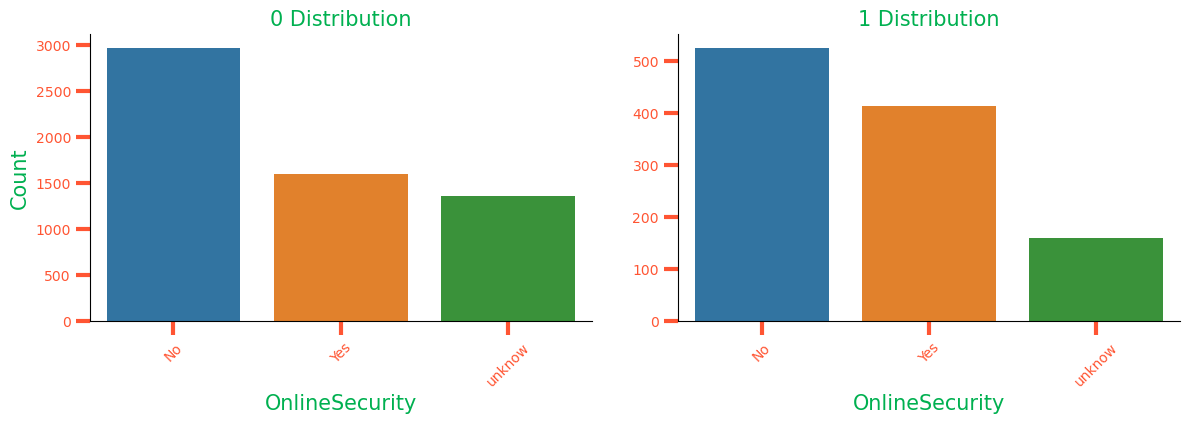

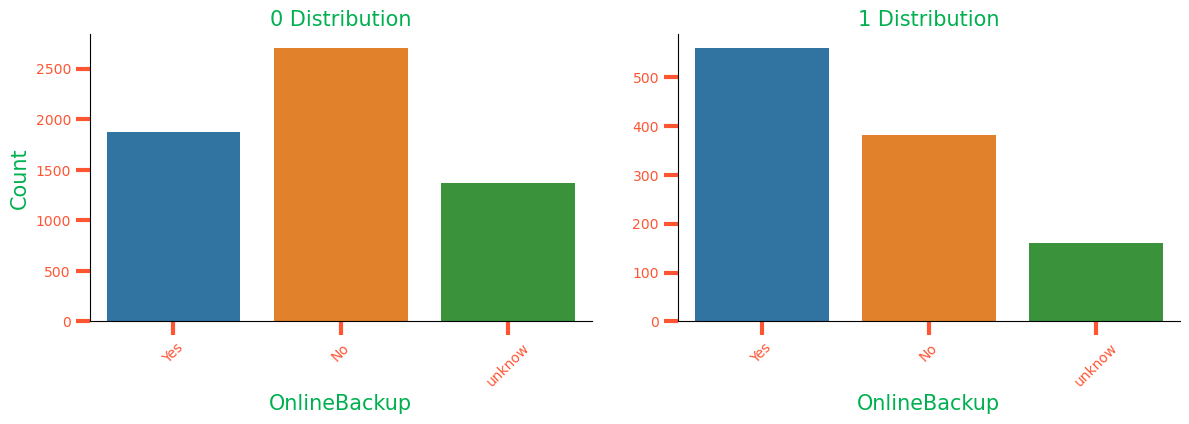

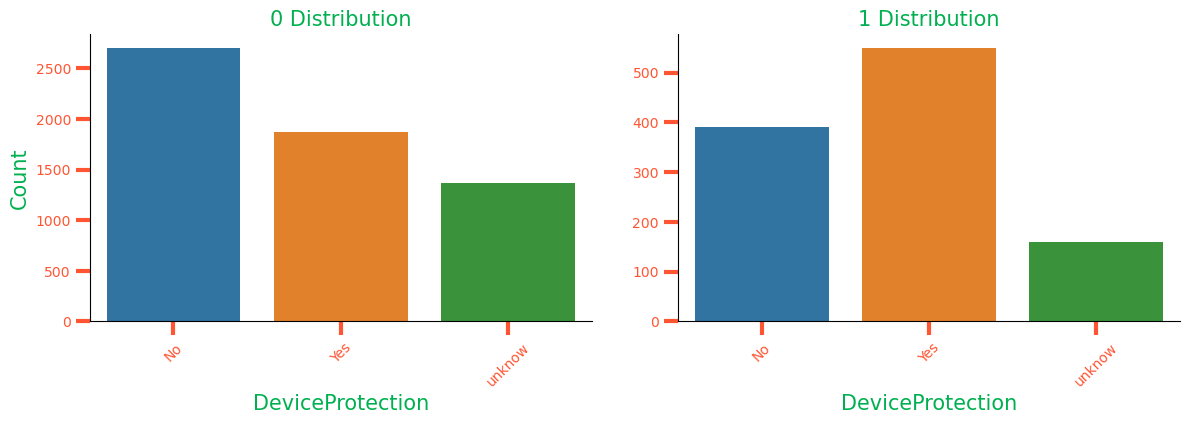

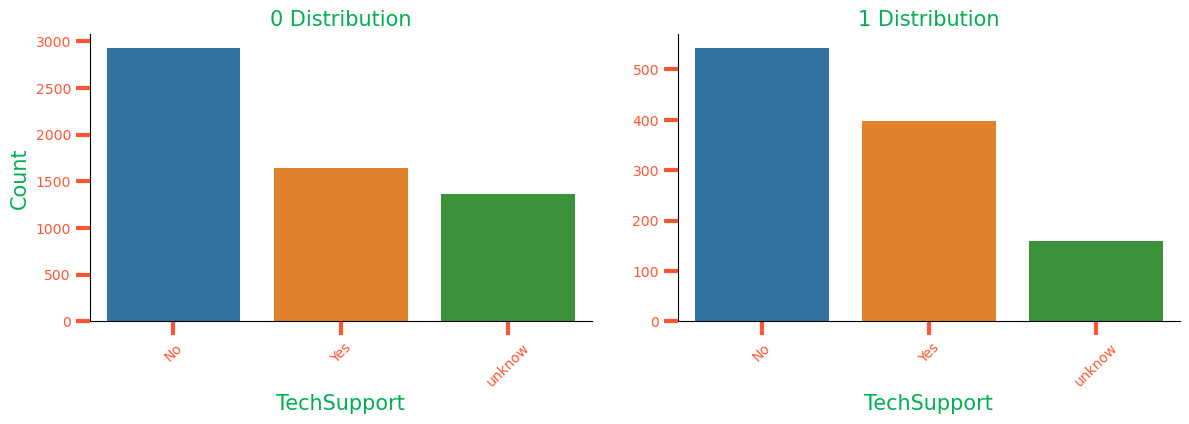

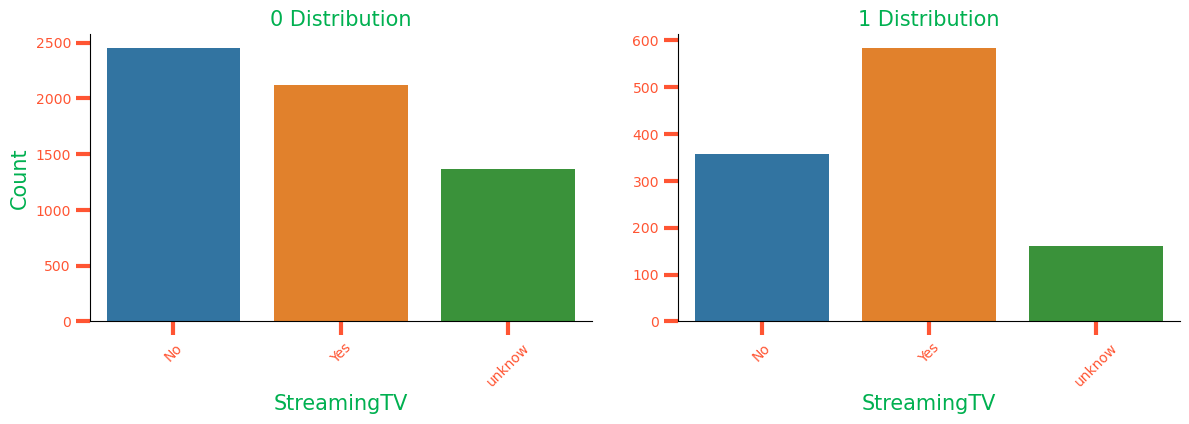

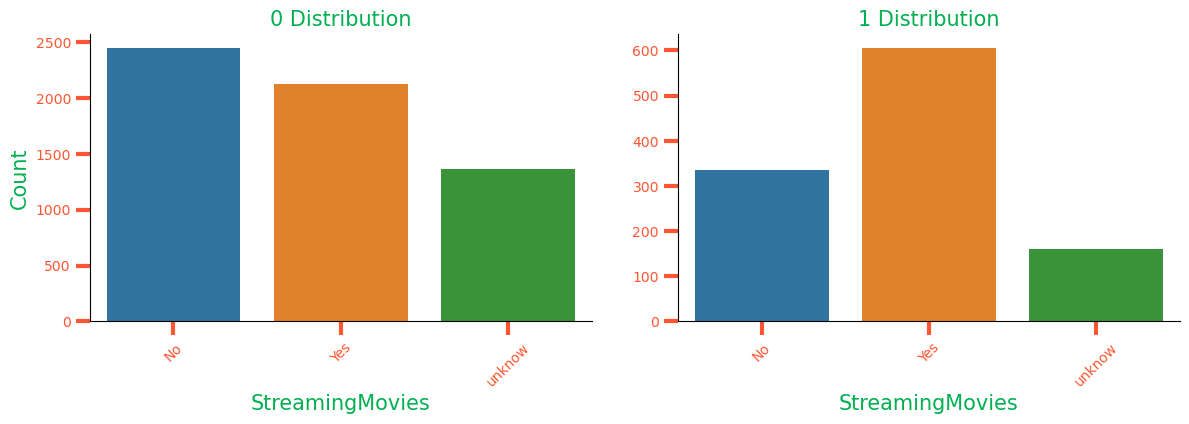

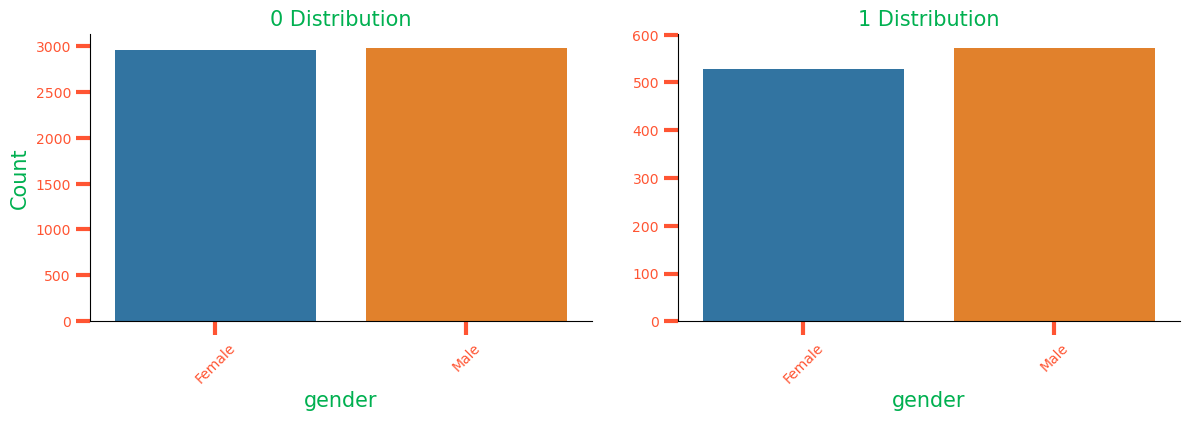

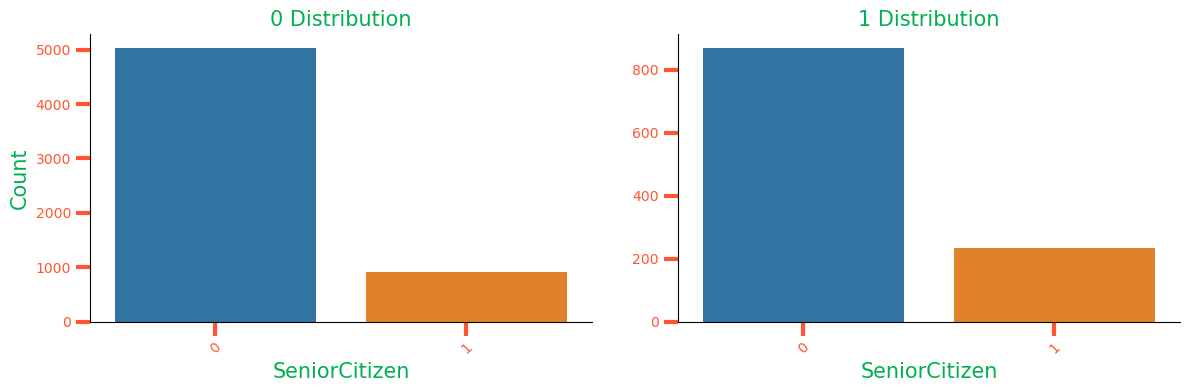

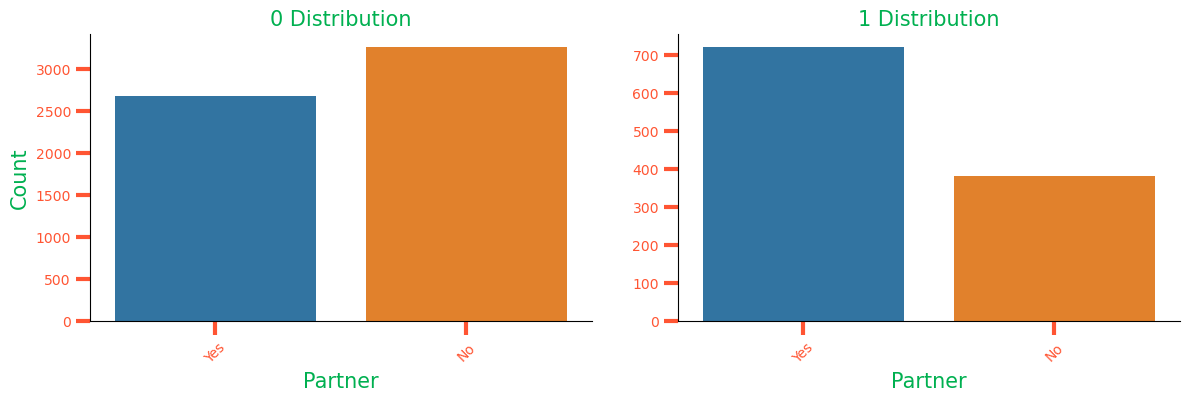

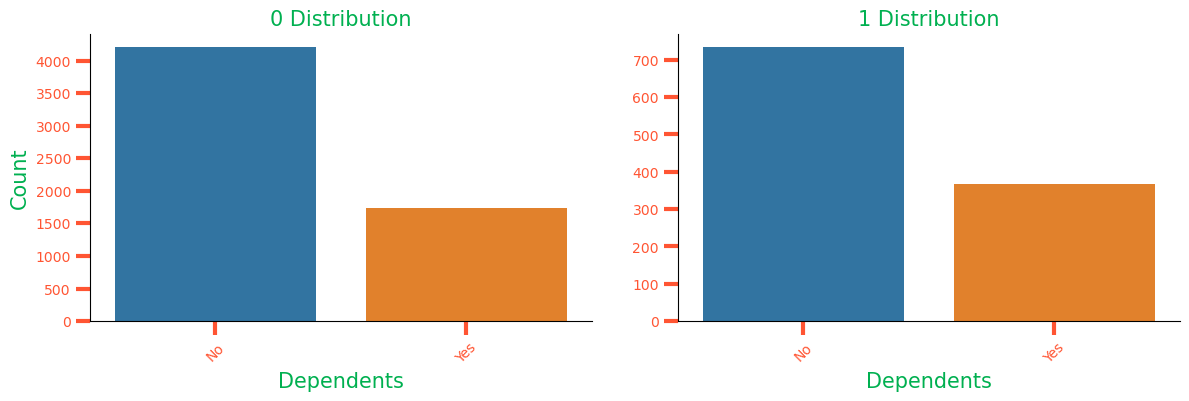

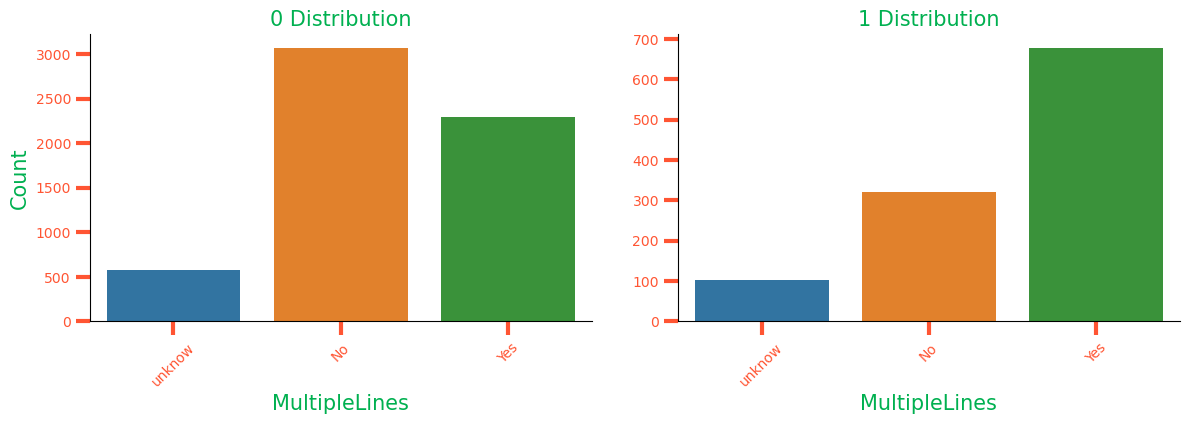

In [24]:
height = 4 
aspect = 1.5

for col in cat_features:
    g = sns.catplot(x=col,
                    kind='count',
                    col='Churn',
                    data=df,
                    sharey=False,
                    height=height,
                    aspect=aspect,
                   )
    
    g.set_xticklabels(rotation=45)
    g.set_axis_labels(col, 'Count')
    g.set_titles("{col_name} Distribution")

Наблюдения:
1. Основной метод оплаты - Month-to-month используют примерно 50% пользователей, два других One yea и Two year используют примерно по 25% пользователей.
2. Использование безбумажной оплаты более популярно.
3. Electronic check больше всего, Mailed check, Credit card, Bank transfer примерно одинаково.
4. Количество женщин и мужчин приблизительно одинаково.
5. Одинокие клиенты чаще уходят из компании.
6. Вероятность ухода клиента меньше, если оплата помесечная.
7. Облочным хранилищем, антивирусом, стриминговым телевидением и каталогом фильмовов чаще пользуются клиенты, расторгающие договор

Создадим признак - количество используемых дополнительных интернет-услуг

In [25]:
products = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df['count_products'] = 0

for col in products:
    df['count_products'] += df[col].apply(lambda x: 1 if x == 'Yes' else 0)

df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churn,period_days,count_products
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,unknow,0,31,1
5575-GNVDE,One year,No,Mailed check,56.95,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1036,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,0,123,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,unknow,0,1371,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,0,153,0


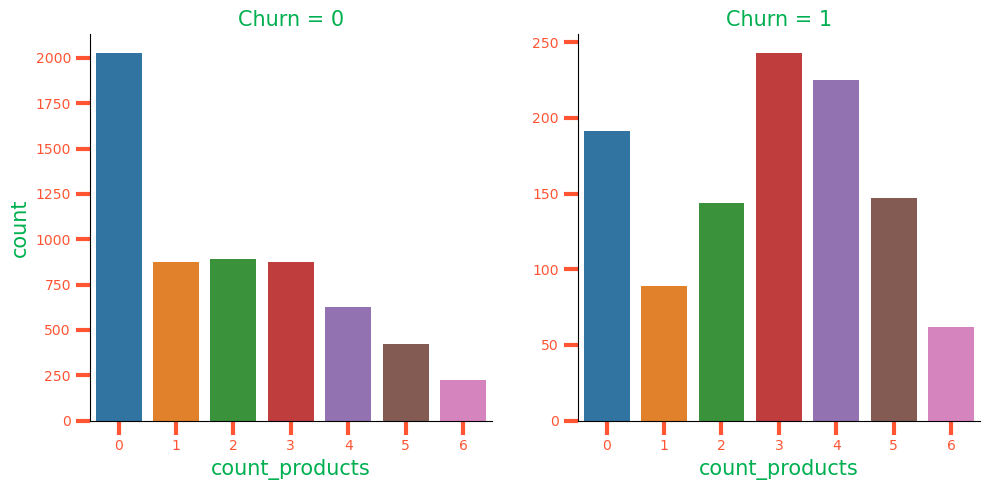

In [26]:
sns.catplot(x='count_products',
            kind='count',
            col='Churn',
            data=df,
            sharey=False,
            )

plt.show()

# Кодирование признаков

In [27]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=df['Churn'],
                                                    random_state=42
                                                   )

In [28]:
cat_features = cat_features.to_list()
numeric_col = X.select_dtypes(exclude='object').columns.to_list()

ohe_features = [col for col in cat_features if df[col].nunique() < 4]
ord_features = [col for col in cat_features if df[col].nunique() >= 4]

In [29]:
ohe_transformer = Pipeline([('onehot', OneHotEncoder())])
ord_transformer = Pipeline([('ordinal', OrdinalEncoder())])
numeric_transformer = Pipeline([('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
                                    ('numeric', numeric_transformer, numeric_col),
                                    ('ohe', ohe_transformer, ohe_features),
                                    ('ord', ord_transformer, ord_features)
                                ])

# LogisticRegression

In [30]:
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('log_reg', LogisticRegression())
                         ])

In [31]:
param_grid_lr = {'log_reg__solver': ['liblinear', 'lbfgs'],
                 'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100]
                }

In [32]:
grid_search_log_reg = GridSearchCV(estimator=pipe_lr,
                                   param_grid=param_grid_lr,
                                   cv=5,
                                   scoring='roc_auc'
                                  )

grid_search_log_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'period_days',
                                                                          'count_products']),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                 

In [33]:
grid_search_log_reg.best_params_

{'log_reg__C': 0.1, 'log_reg__solver': 'liblinear'}

In [34]:
best_model_log_reg = grid_search_log_reg.best_estimator_

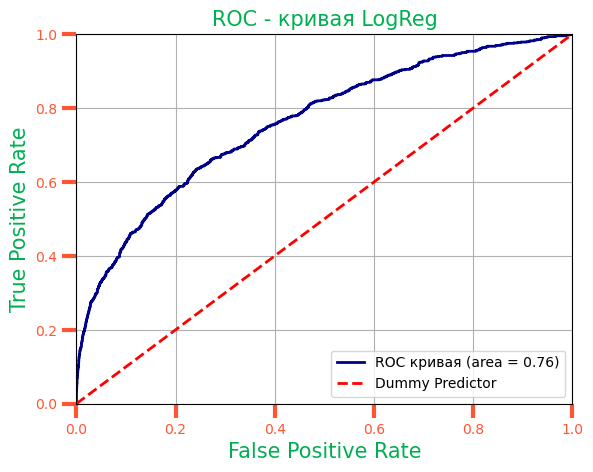

In [35]:
fpr, tpr, thr = roc_curve(y_train,
                          best_model_log_reg.predict_proba(X_train)[:, 1]
                         )

roc_auc = roc_auc_score(y_train,
                        best_model_log_reg.predict_proba(X_train)[:, 1]
                       )

plt.plot(fpr,
         tpr,
         color='darkblue',
         label='ROC кривая (area = %0.2f)'% roc_auc
        )

plt.plot([0, 1],
         [0, 1],
         color='red',
         linestyle='--',
         label='Dummy Predictor'
        )

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC - кривая LogReg')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# CatBoost

In [43]:
params_cb = {'cat_features': cat_features,
             'verbose': 100,
             'auto_class_weights':'Balanced',
             'random_seed': 42
             }

In [44]:
grid_cb = {'learning_rate': [0.001, 0.01, 0.1, 1],
           'depth': [2, 5, 10]
          }

In [45]:
model_cb = CatBoostClassifier(**params_cb)

In [46]:
search_cb = GridSearchCV(estimator=model_cb,
                         param_grid=grid_cb,
                         cv=3,
                         scoring='roc_auc'
                        )

search_cb.fit(X_train, y_train)

0:	learn: 0.6929444	total: 159ms	remaining: 2m 39s
100:	learn: 0.6756631	total: 1.69s	remaining: 15.1s
200:	learn: 0.6617892	total: 3.22s	remaining: 12.8s
300:	learn: 0.6498729	total: 4.75s	remaining: 11s
400:	learn: 0.6386880	total: 6.26s	remaining: 9.35s
500:	learn: 0.6290995	total: 7.77s	remaining: 7.74s
600:	learn: 0.6200526	total: 9.28s	remaining: 6.16s
700:	learn: 0.6116468	total: 10.8s	remaining: 4.61s
800:	learn: 0.6041699	total: 12.3s	remaining: 3.06s
900:	learn: 0.5972963	total: 13.8s	remaining: 1.52s
999:	learn: 0.5912320	total: 15.3s	remaining: 0us
0:	learn: 0.6930081	total: 10ms	remaining: 10s
100:	learn: 0.6787890	total: 1.54s	remaining: 13.7s
200:	learn: 0.6664270	total: 3.06s	remaining: 12.2s
300:	learn: 0.6556435	total: 4.57s	remaining: 10.6s
400:	learn: 0.6463327	total: 6.08s	remaining: 9.07s
500:	learn: 0.6383264	total: 7.75s	remaining: 7.72s
600:	learn: 0.6308839	total: 9.69s	remaining: 6.43s
700:	learn: 0.6238778	total: 11.6s	remaining: 4.93s
800:	learn: 0.6176469	

600:	learn: 0.5734529	total: 20.6s	remaining: 13.7s
700:	learn: 0.5633885	total: 24s	remaining: 10.2s
800:	learn: 0.5547737	total: 27.3s	remaining: 6.78s
900:	learn: 0.5475646	total: 30.7s	remaining: 3.37s
999:	learn: 0.5413239	total: 34.1s	remaining: 0us
0:	learn: 0.6899187	total: 29.6ms	remaining: 29.5s
100:	learn: 0.5342427	total: 3.67s	remaining: 32.7s
200:	learn: 0.4980416	total: 6.86s	remaining: 27.3s
300:	learn: 0.4804154	total: 9.89s	remaining: 23s
400:	learn: 0.4686838	total: 12.9s	remaining: 19.2s
500:	learn: 0.4598572	total: 15.9s	remaining: 15.8s
600:	learn: 0.4515865	total: 19s	remaining: 12.6s
700:	learn: 0.4458375	total: 21.8s	remaining: 9.29s
800:	learn: 0.4384756	total: 24.9s	remaining: 6.18s
900:	learn: 0.4291733	total: 28.1s	remaining: 3.09s
999:	learn: 0.4163454	total: 31.5s	remaining: 0us
0:	learn: 0.6904549	total: 29.8ms	remaining: 29.8s
100:	learn: 0.5587953	total: 3.36s	remaining: 29.9s
200:	learn: 0.5241896	total: 6.43s	remaining: 25.6s
300:	learn: 0.5073514	to

100:	learn: 0.4964730	total: 5.64s	remaining: 50.2s
200:	learn: 0.4340366	total: 11s	remaining: 43.6s
300:	learn: 0.4048859	total: 16.1s	remaining: 37.4s
400:	learn: 0.3812623	total: 20.8s	remaining: 31s
500:	learn: 0.3605431	total: 25.8s	remaining: 25.7s
600:	learn: 0.3445137	total: 30.5s	remaining: 20.2s
700:	learn: 0.3277380	total: 35.1s	remaining: 15s
800:	learn: 0.3061415	total: 40.4s	remaining: 10s
900:	learn: 0.2765398	total: 46.9s	remaining: 5.16s
999:	learn: 0.2507069	total: 53.4s	remaining: 0us
0:	learn: 0.6627505	total: 34.5ms	remaining: 34.5s
100:	learn: 0.2566446	total: 5.15s	remaining: 45.8s
200:	learn: 0.1155418	total: 12.5s	remaining: 49.5s
300:	learn: 0.0615170	total: 20s	remaining: 46.5s
400:	learn: 0.0418929	total: 27.3s	remaining: 40.7s
500:	learn: 0.0307012	total: 34.6s	remaining: 34.5s
600:	learn: 0.0230524	total: 41.9s	remaining: 27.8s
700:	learn: 0.0183805	total: 49.4s	remaining: 21.1s
800:	learn: 0.0154689	total: 56.8s	remaining: 14.1s
900:	learn: 0.0134560	tot

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000029587836730>,
             param_grid={'depth': [2, 5, 10],
                         'learning_rate': [0.001, 0.01, 0.1, 1]},
             scoring='roc_auc')

In [48]:
search_cb.best_params_

{'depth': 2, 'learning_rate': 1}

In [49]:
print(f'Значение ROC-AUC на кроссвалидации: {search_cb.best_score_:0.3f}')

Значение ROC-AUC на кроссвалидации: 0.912


# CatBoost на test

In [50]:
best_model_catboost = search_cb.best_estimator_

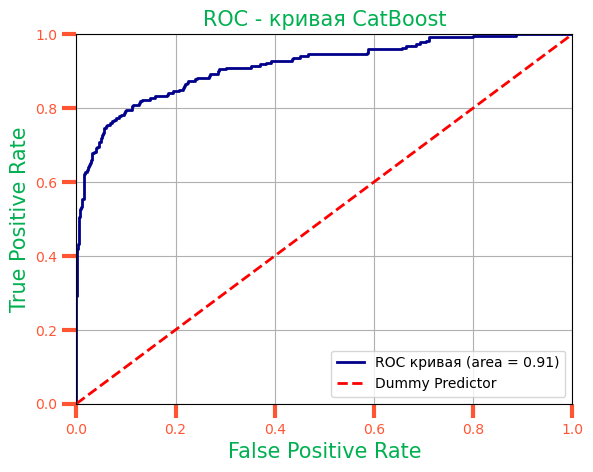

In [51]:
fpr, tpr, thr = roc_curve(y_test,
                          best_model_catboost.predict_proba(X_test)[:, 1]
                         )

roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         color='darkblue',
         label='ROC кривая (area = %0.2f)'% roc_auc
        )

plt.plot([0, 1],
         [0, 1],
         color='red',
         linestyle='--',
         label='Dummy Predictor'
        )

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC - кривая CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

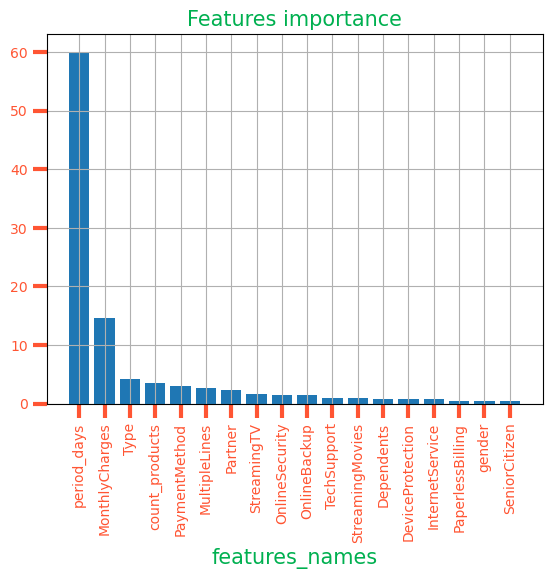

In [64]:
fi_df = pd.DataFrame({'feature_names': X.columns,
                      'feature_importance': best_model_catboost.feature_importances_
                     })

fi_df = fi_df.sort_values(by='feature_importance', ascending=False)

plt.bar(x=fi_df['feature_names'],
        height=fi_df['feature_importance'],
       )

plt.title('Features importance')
plt.xticks(rotation=90)
plt.xlabel('features_names')
plt.grid()
plt.show()

# Вывод:

В рамках данного проекта было выполнено:
1. На первом этапе был собран датасет из 4 исходных таблиц, соединенный по `customerID `. После сборки образовались пропуски, так как в 2-х датасетах отсутствовали часть клинтов. Пропуски в признаках были заполнены.
2. Предобрабодка данных, были помененены типы данных у признаков `BeginDate`, `EndDate` - на `datetime`, а у `MonthlyCharges` и `TotalCharges` на `float`. Добавлен признак `period`, показывающий продолжительность времени использовния услуг на момент выгрузки данных. Выделен целевой признак `Churn` означающий факт ухода клиента (1- клиент ушел, 0 - остался).
3. Перед обучением были удалены признаки `BeginDate` и `EndDate`, так как вместо них был добавлен признак `period`. Удален `gender` по причине отсутствия влияния на целевой признак и удален `TotalCharges`, чтобы избежать мультиколлиниарности для линейной модели.
4. После более детального рассмотрения, удалось сделать следующие выводы:
- основной метод оплаты - Month-to-month используют примерно 50% пользователей, два других One yea и Two year используют примерно по 25% пользователей;
- использование безбумажной оплаты более популярно;
- Electronic check больше всего, Mailed check, Credit card, Bank transfer примерно одинаково;
- количество женщин и мужчин приблизительно одинаково;
- одинокие клиенты чаще уходят из компании;
- вероятность ухода клиента меньше, если оплата помесечная;
5. Дальнейшем этапом работы стала подготовка данных для обучения моделей и обучение на кроссвалидации. В рамках проекта было рассмотрено 2 модели: LogisticRegression и CatBoostClassifier. Для логистической регрессии была произведена предобработка - кодирование категориальных признаков и масштабирование числовых. Обучение производилось на всех фичах, за исключением `BeginDate`, `EndDate`, `TotalCharges`, `gender`. И добавлены новые: `period`, `count_products` и целевой `Churn`. С помощью CatBoost этапы кодирование и масштабирования удалось избежать, используя встроенный параметр для работы с категориальными признаками, которых у нас большинство.
6. Лучшая модель CatBoost на тестовой выборке показала ROC-AUC=0.91.